In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import logging
from IPython import display

logging.getLogger("kedro.ipython").disabled = True

logging.getLogger("kedro.io.data_catalog").disabled = True

%load_ext kedro.ipython
warnings.filterwarnings('ignore')
display.clear_output()
pd.set_option('display.max_rows', 500)

# Dataset Loading

In [2]:
df = catalog.load('depression_synthetic')
df.info()

[11/29/24 01:54:43] INFO     Loading data from depression_synthetic (CSVDataset)...             ]8;id=866939;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=561226;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py#539\539]8;;\

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

In [3]:
df.isnull().sum()


id                                            0
Name                                          0
Gender                                        0
Age                                           0
City                                          0
Working Professional or Student               0
Profession                                36630
Academic Pressure                        112803
Work Pressure                             27918
CGPA                                     112802
Study Satisfaction                       112803
Job Satisfaction                          27910
Sleep Duration                                0
Dietary Habits                                4
Degree                                        2
Have you ever had suicidal thoughts ?         0
Work/Study Hours                              0
Financial Stress                              4
Family History of Mental Illness              0
Depression                                    0
dtype: int64

In [4]:
df.nunique().sort_values()


Gender                                        2
Working Professional or Student               2
Have you ever had suicidal thoughts ?         2
Depression                                    2
Family History of Mental Illness              2
Job Satisfaction                              5
Study Satisfaction                            5
Academic Pressure                             5
Work Pressure                                 5
Financial Stress                              5
Work/Study Hours                             13
Dietary Habits                               23
Sleep Duration                               36
Age                                          43
Profession                                   64
City                                         98
Degree                                      115
CGPA                                        331
Name                                        422
id                                       140700
dtype: int64

In [5]:
df = df.drop(["id"], axis=1)

# Object cols

In [6]:
df.describe(include="object")

,Name,Gender,City,Working Professional or Student,Profession,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Family History of Mental Illness
count,140700,140700,140700,140700,104070,140700,140696,140698,140700,140700
unique,422,2,98,2,64,36,23,115,2,2
top,Rohan,Male,Kalyan,Working Professional,Teacher,Less than 5 hours,Moderate,Class 12,No,No
freq,3178,77464,6591,112799,24906,38784,49705,14729,71138,70758


In [7]:
object_cols = [col for col in df.columns if df[col].dtype == "object"]

## Make plots of all the unique values

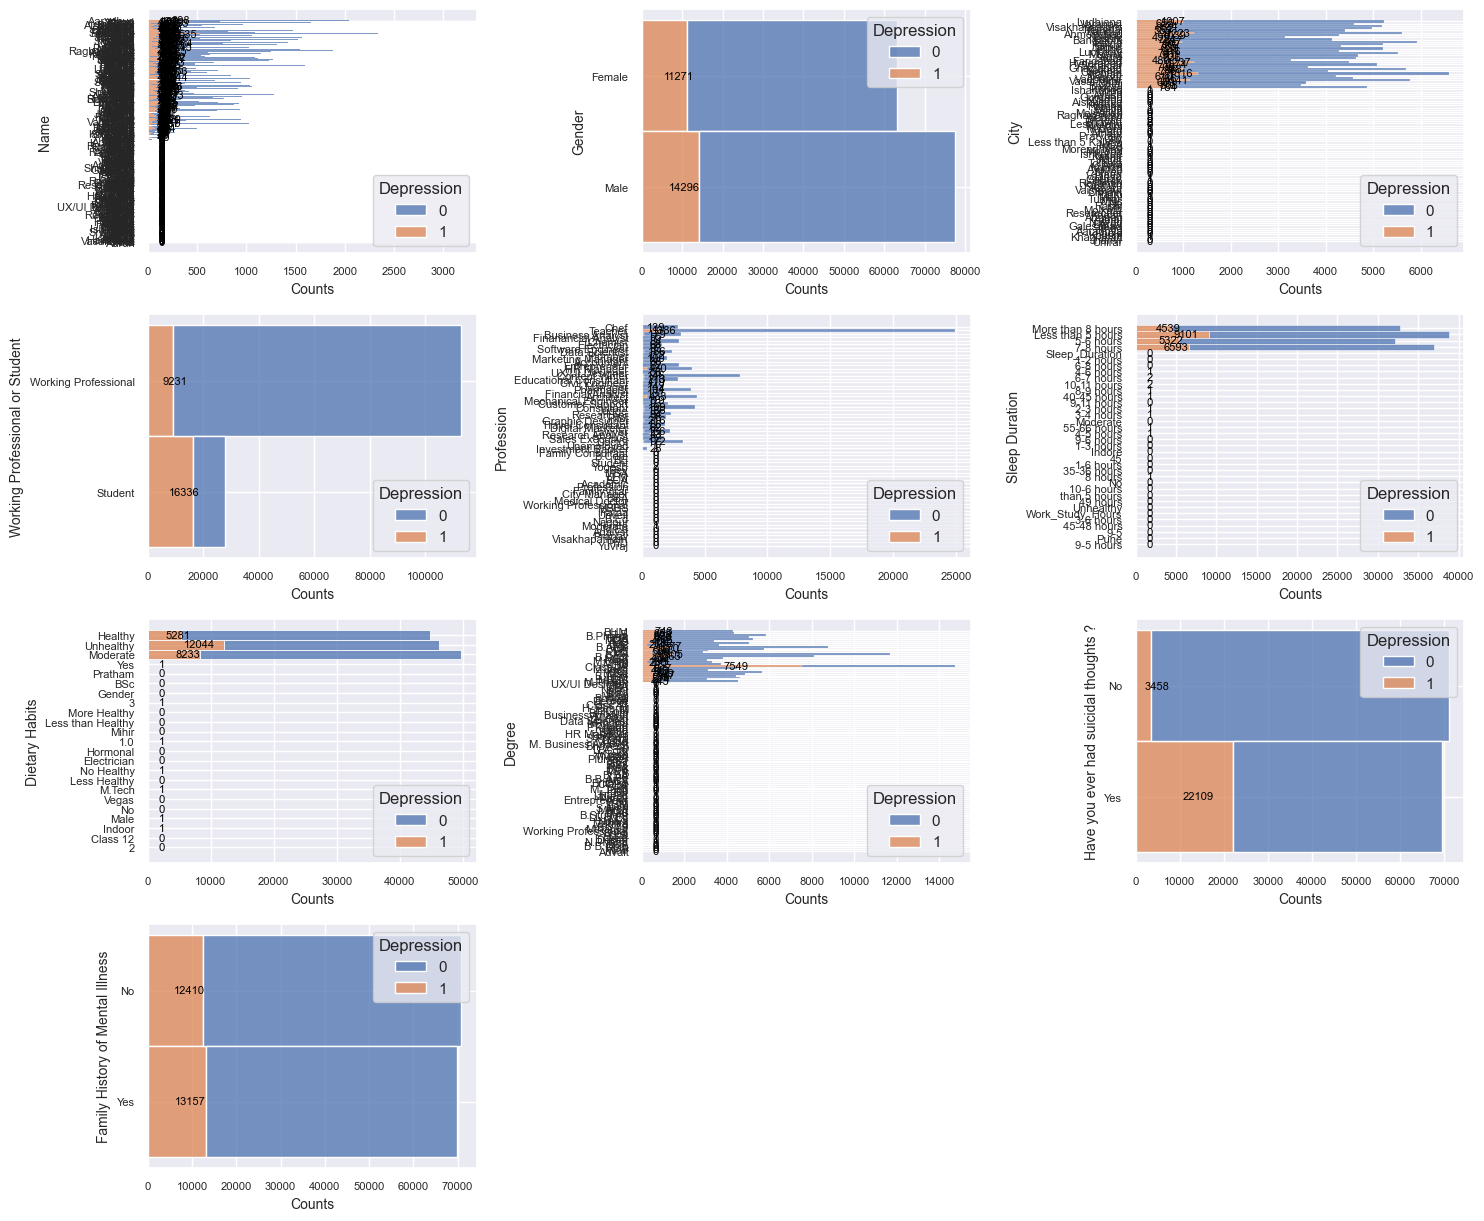

In [8]:
fig = plt.figure(figsize=(15, 15))

for i, feature in enumerate(object_cols):
    ax = fig.add_subplot(5, 3, i+1)
    # df_temp = df[feature].value_counts().reset_index()
    sns.histplot(data=df, y=feature, hue='Depression', multiple="stack")
    # sns.barplot(df_temp, y=feature, x="count", orient="h", alpha=0.8)
    ax.bar_label(
        ax.containers[0], label_type="center", padding=10, color="black", fontsize=8
    )
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xlabel("Counts", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)


fig.tight_layout()
plt.show()

## N-largest 20

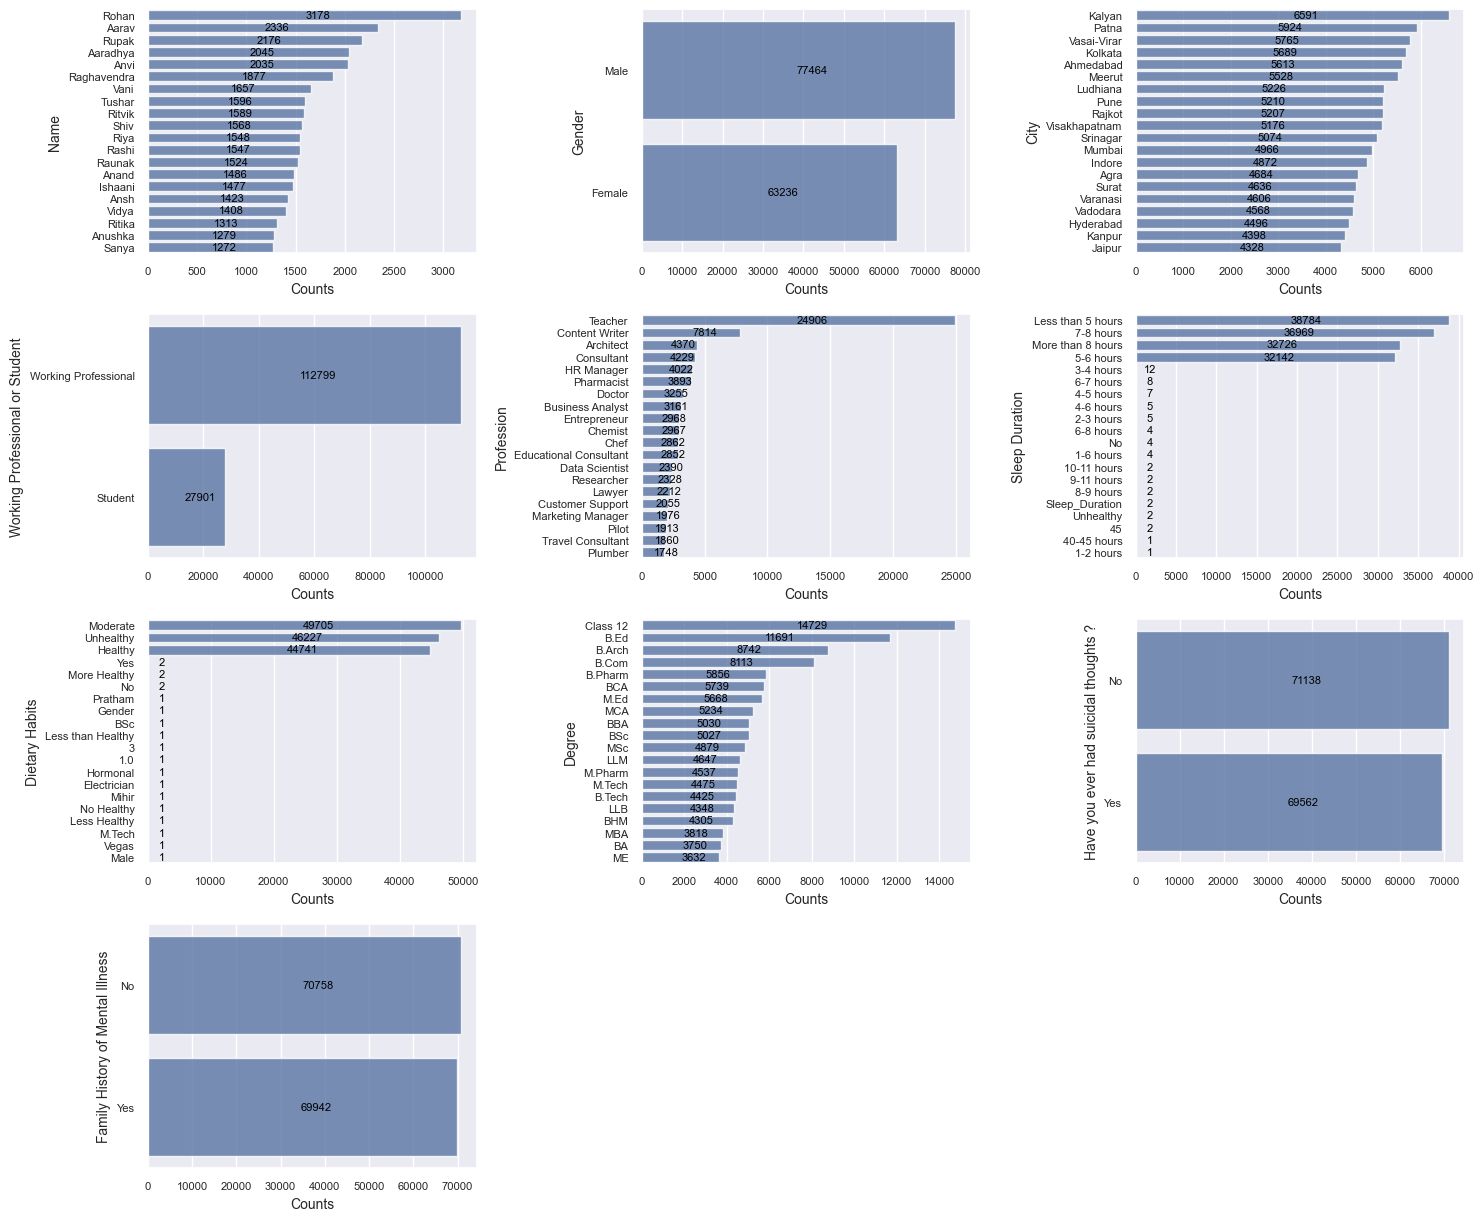

In [9]:
fig = plt.figure(figsize=(15, 15))

for i, feature in enumerate(object_cols):
    ax = fig.add_subplot(5, 3, i+1)
    df_temp = df[feature].value_counts().nlargest(20).reset_index()
    sns.barplot(df_temp, y=feature, x="count", orient="h", alpha=0.8)
    ax.bar_label(
        ax.containers[0], label_type="center", padding=10, color="black", fontsize=8
    )
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xlabel("Counts", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)


fig.tight_layout()
plt.show()

## Insights till now

Ok some interesting insights we get from the data are:

1. Males may have more depression rates.
2. More than 50% of students have depression.
3. Some professions have higher depression rates.
4. Sleep affects depression.
5. Unhealthy Diet is a depression.
6. Some degrees have way too much depression.
7. People who have had suicidal thoughts are more prone to depression.
8. Family history doesn't matter.

## Columns to fix

1. City
2. Profession
3. Sleep Duration
4. Dietary Habits
5. Degree

We don't fix name as that can be anything. It also doesn't have any null values. Other columns have weird values.

In [10]:
# Utility for visualization
def sns_histplot(df, col):
    print(f"====={col}=====")
    print(df[col].describe())
    sns.histplot(data=df, x=col, hue='Depression', multiple="stack")
    plt.xticks(rotation=90)
    plt.show()
    print("================")

## Cleaning city

=====City=====
count     140700
unique        98
top       Kalyan
freq        6591
Name: City, dtype: object


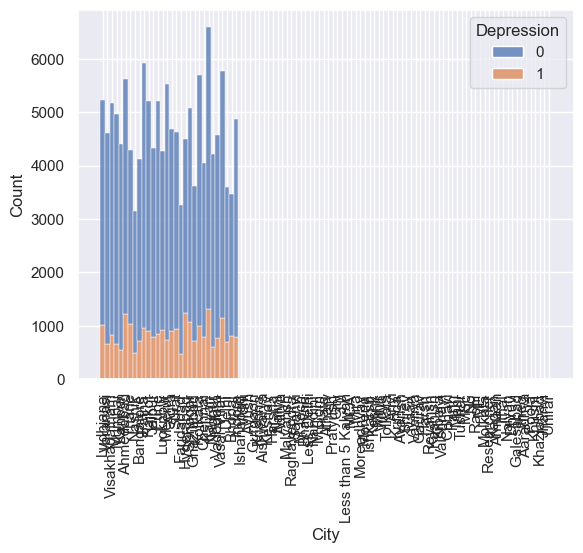

In [11]:
sns_histplot(df, 'City')

In [12]:
# check unique values
df['City'].unique()


array(['Ludhiana', 'Varanasi', 'Visakhapatnam', 'Mumbai', 'Kanpur',
       'Ahmedabad', 'Thane', 'Nashik', 'Bangalore', 'Patna', 'Rajkot',
       'Jaipur', 'Pune', 'Lucknow', 'Meerut', 'Agra', 'Surat',
       'Faridabad', 'Hyderabad', 'Srinagar', 'Ghaziabad', 'Kolkata',
       'Chennai', 'Kalyan', 'Nagpur', 'Vadodara', 'Vasai-Virar', 'Delhi',
       'Bhopal', 'Indore', 'Ishanabad', 'Vidhi', 'Ayush', 'Gurgaon',
       'Krishna', 'Aishwarya', 'Keshav', 'Harsha', 'Nalini', 'Aditya',
       'Malyansh', 'Raghavendra', 'Saanvi', 'M.Tech', 'Bhavna',
       'Less Delhi', 'Nandini', 'M.Com', 'Plata', 'Atharv', 'Pratyush',
       'City', '3.0', 'Less than 5 Kalyan', 'MCA', 'Mira', 'Moreadhyay',
       'Morena', 'Ishkarsh', 'Kashk', 'Mihir', 'Vidya', 'Tolkata', 'Anvi',
       'Krinda', 'Ayansh', 'Shrey', 'Ivaan', 'Vaanya', 'Gaurav', 'Harsh',
       'Reyansh', 'Kashish', 'Kibara', 'Vaishnavi', 'Chhavi', 'Parth',
       'Mahi', 'Tushar', 'MSc', 'No', 'Rashi', 'ME', 'Molkata',
       'Researcher', 

In [13]:
# check number of depressed per city

unique_cities = df['City'].unique()

print(f"We have {len(unique_cities)} Unique Cities")
print()

for city in unique_cities:
    print(f"{city} has {df[df['City']==city][df['Depression'] == 1.0].count()[0]} Depressed People.")

We have 98 Unique Cities

Ludhiana has 1007 Depressed People.
Varanasi has 655 Depressed People.
Visakhapatnam has 824 Depressed People.
Mumbai has 652 Depressed People.
Kanpur has 553 Depressed People.
Ahmedabad has 1223 Depressed People.
Thane has 1039 Depressed People.
Nashik has 499 Depressed People.
Bangalore has 724 Depressed People.
Patna has 967 Depressed People.
Rajkot has 902 Depressed People.
Jaipur has 785 Depressed People.
Pune has 839 Depressed People.
Lucknow has 916 Depressed People.
Meerut has 741 Depressed People.
Agra has 901 Depressed People.
Surat has 936 Depressed People.
Faridabad has 480 Depressed People.
Hyderabad has 1237 Depressed People.
Srinagar has 1074 Depressed People.
Ghaziabad has 706 Depressed People.
Kolkata has 988 Depressed People.
Chennai has 786 Depressed People.
Kalyan has 1316 Depressed People.
Nagpur has 610 Depressed People.
Vadodara has 766 Depressed People.
Vasai-Virar has 1141 Depressed People.
Delhi has 689 Depressed People.
Bhopal has 80

In [14]:
# Remove fraud entries
list_of_cities_removed = []
for city in unique_cities:
    num_depressed_people = df[df['City']==city][df['Depression'] == 1.0].count()[0]
    if num_depressed_people < 5:
        print(f"{city} has {num_depressed_people} Depressed People.")
        df = df[df['City'] != city]
        list_of_cities_removed.append(city)

Ishanabad has 1 Depressed People.
Vidhi has 0 Depressed People.
Ayush has 0 Depressed People.
Gurgaon has 0 Depressed People.
Krishna has 0 Depressed People.
Aishwarya has 0 Depressed People.
Keshav has 0 Depressed People.
Harsha has 1 Depressed People.
Nalini has 1 Depressed People.
Aditya has 0 Depressed People.
Malyansh has 0 Depressed People.
Raghavendra has 0 Depressed People.
Saanvi has 3 Depressed People.
M.Tech has 0 Depressed People.
Bhavna has 2 Depressed People.
Less Delhi has 0 Depressed People.
Nandini has 0 Depressed People.
M.Com has 1 Depressed People.
Plata has 0 Depressed People.
Atharv has 0 Depressed People.
Pratyush has 0 Depressed People.
City has 1 Depressed People.
3.0 has 1 Depressed People.
Less than 5 Kalyan has 0 Depressed People.
MCA has 1 Depressed People.
Mira has 1 Depressed People.
Moreadhyay has 0 Depressed People.
Morena has 0 Depressed People.
Ishkarsh has 0 Depressed People.
Kashk has 0 Depressed People.
Mihir has 1 Depressed People.
Vidya has 0 Dep

=====City=====
count     140602
unique        30
top       Kalyan
freq        6591
Name: City, dtype: object


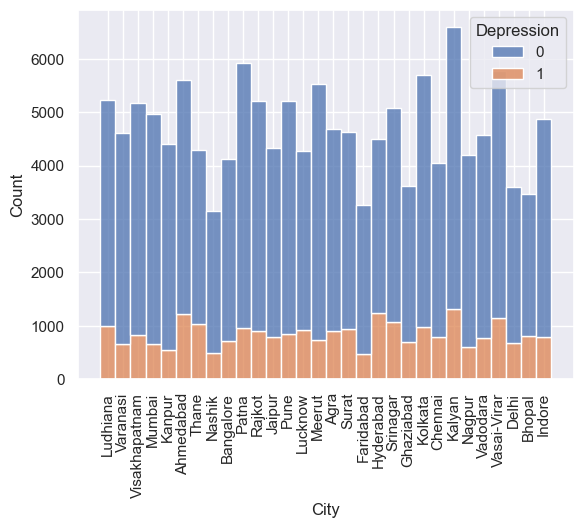

In [15]:
sns_histplot(df, 'City')

## Cleaning Profession

=====Profession=====
count      104000
unique         64
top       Teacher
freq        24896
Name: Profession, dtype: object


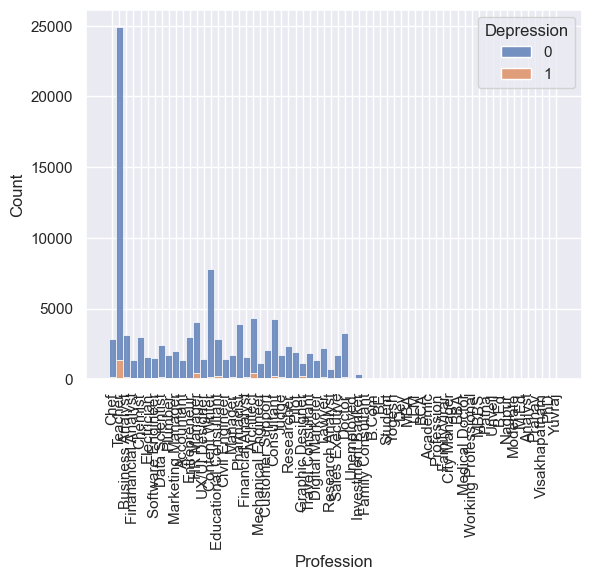

In [16]:
sns_histplot(df, 'Profession')

In [17]:
df['Profession'].unique()


array(['Chef', 'Teacher', nan, 'Business Analyst', 'Finanancial Analyst',
       'Chemist', 'Electrician', 'Software Engineer', 'Data Scientist',
       'Plumber', 'Marketing Manager', 'Accountant', 'Entrepreneur',
       'HR Manager', 'UX/UI Designer', 'Content Writer',
       'Educational Consultant', 'Civil Engineer', 'Manager',
       'Pharmacist', 'Financial Analyst', 'Architect',
       'Mechanical Engineer', 'Customer Support', 'Consultant', 'Judge',
       'Researcher', 'Pilot', 'Graphic Designer', 'Travel Consultant',
       'Digital Marketer', 'Lawyer', 'Research Analyst',
       'Sales Executive', 'Doctor', 'Unemployed', 'Investment Banker',
       'Family Consultant', 'B.Com', 'BE', 'Student', 'Yogesh', 'Dev',
       'MBA', 'LLM', 'BCA', 'Academic', 'Profession', 'FamilyVirar',
       'City Manager', 'BBA', 'Medical Doctor', 'Working Professional',
       'MBBS', 'Patna', 'Unveil', 'B.Ed', 'Nagpur', 'Moderate', 'M.Ed',
       'Analyst', 'Pranav', 'Visakhapatnam', 'PhD', 'Y

In [18]:
df["Profession"].value_counts()[1:35].reset_index()['Profession'].to_list()


[
    'Content Writer',
    'Architect',
    'Consultant',
    'HR Manager',
    'Pharmacist',
    'Doctor',
    'Business Analyst',
    'Chemist',
    'Entrepreneur',
    'Chef',
    'Educational Consultant',
    'Data Scientist',
    'Researcher',
    'Lawyer',
    'Customer Support',
    'Marketing Manager',
    'Pilot',
    'Travel Consultant',
    'Plumber',
    'Sales Executive',
    'Manager',
    'Judge',
    'Electrician',
    'Financial Analyst',
    'Software Engineer',
    'Civil Engineer',
    'UX/UI Designer',
    'Digital Marketer',
    'Accountant',
    'Finanancial Analyst',
    'Mechanical Engineer',
    'Graphic Designer',
    'Research Analyst',
    'Investment Banker'
]

In [19]:
pro = df["Profession"].value_counts()[1:35].reset_index()["Profession"].to_list()
df["Profession"] = np.where(df["Profession"].isin(pro), df["Profession"], "Other")

=====Profession=====
count     140602
unique        35
top        Other
freq       61548
Name: Profession, dtype: object


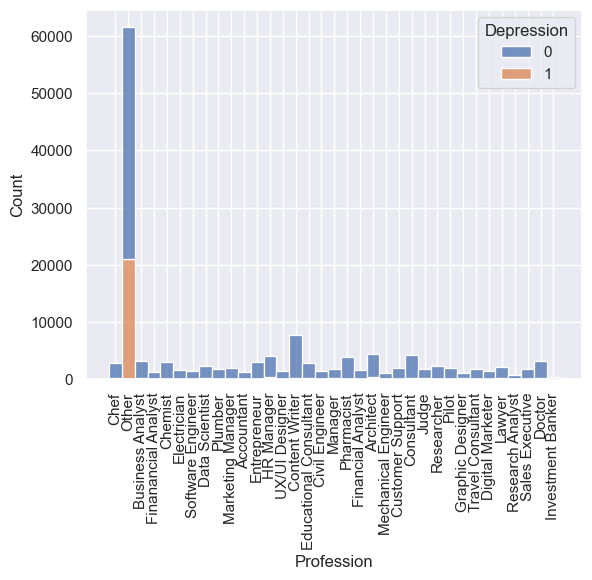

In [20]:
sns_histplot(df, 'Profession')

## Cleaning Sleep Duration

=====Sleep Duration=====
count                140602
unique                   36
top       Less than 5 hours
freq                  38761
Name: Sleep Duration, dtype: object


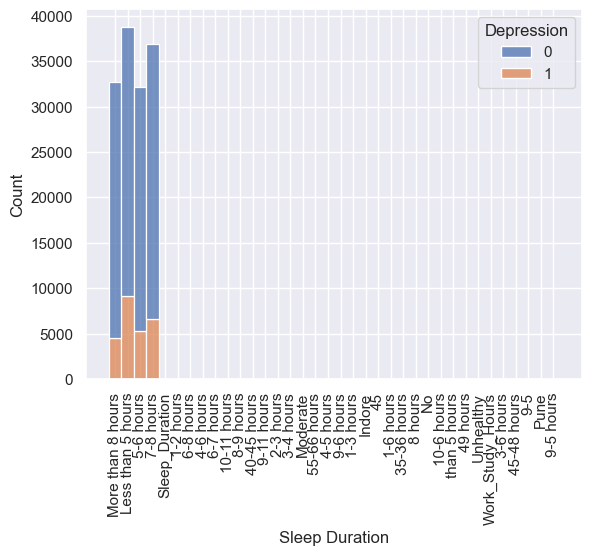

In [21]:
sns_histplot(df, 'Sleep Duration')

In [22]:
sd = df["Sleep Duration"].value_counts()[0:4].reset_index()['Sleep Duration'].to_list()
df["Sleep Duration"] = np.where(df["Sleep Duration"].isin(sd), df["Sleep Duration"], "1-8")

=====Sleep Duration=====
count                140602
unique                    5
top       Less than 5 hours
freq                  38761
Name: Sleep Duration, dtype: object


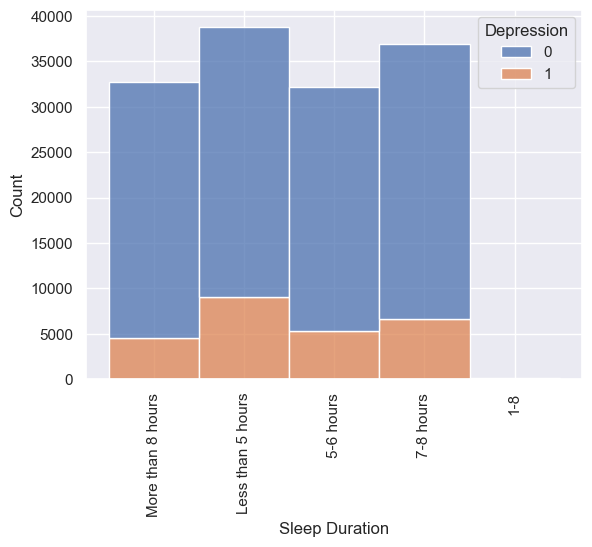

In [23]:
sns_histplot(df, 'Sleep Duration')

In [24]:
df['Sleep Duration'].value_counts()


Sleep Duration
Less than 5 hours    38761
7-8 hours            36933
More than 8 hours    32709
5-6 hours            32120
1-8                     79
Name: count, dtype: int64

## Cleaning Dietary Habits

=====Dietary Habits=====
count       140598
unique          23
top       Moderate
freq         49668
Name: Dietary Habits, dtype: object


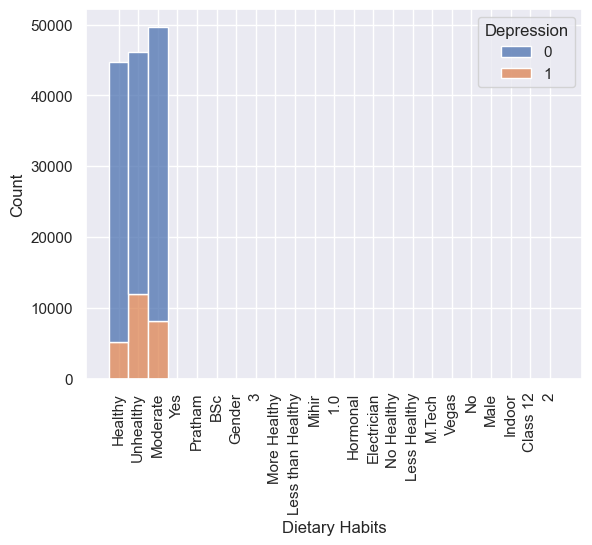

In [25]:
sns_histplot(df, 'Dietary Habits')

In [26]:
dh = df['Dietary Habits'].value_counts()[0:3].reset_index()['Dietary Habits'].to_list()
df['Dietary Habits'] = np.where(df['Dietary Habits'].isin(dh), df['Dietary Habits'], 'Moderate')

=====Dietary Habits=====
count       140602
unique           3
top       Moderate
freq         49695
Name: Dietary Habits, dtype: object


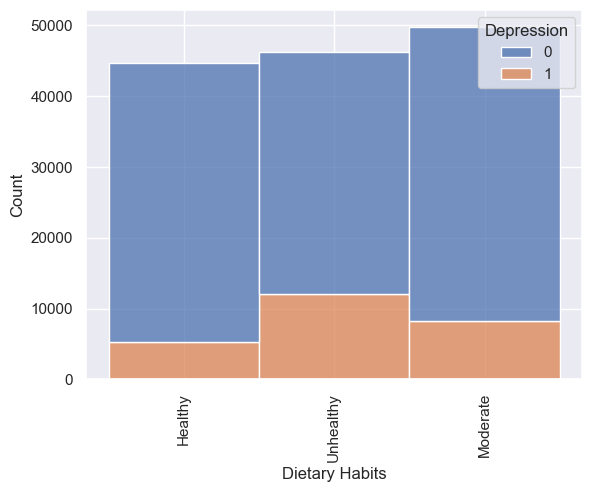

In [27]:
sns_histplot(df, 'Dietary Habits')

## Cleaning Degree

=====Degree=====
count       140600
unique         114
top       Class 12
freq         14722
Name: Degree, dtype: object


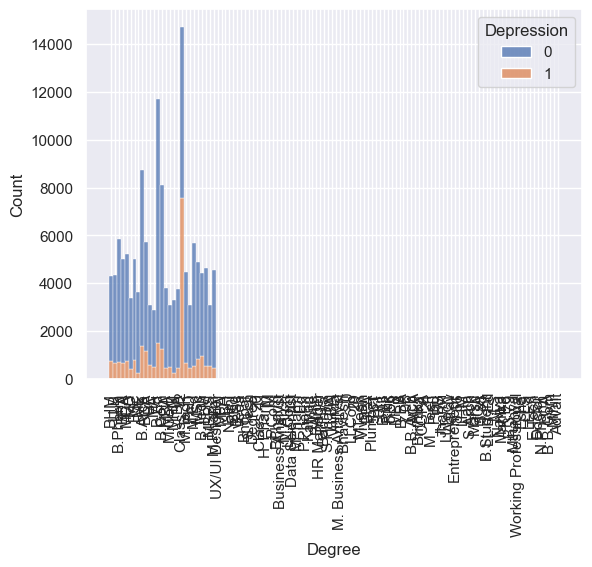

In [28]:
sns_histplot(df, 'Degree')

In [29]:
deg = df['Degree'].value_counts()[:27].reset_index()['Degree'].to_list()
df['Degree'] = np.where(df['Degree'].isin(deg), df['Degree'], "Other")

=====Degree=====
count       140602
unique          28
top       Class 12
freq         14722
Name: Degree, dtype: object


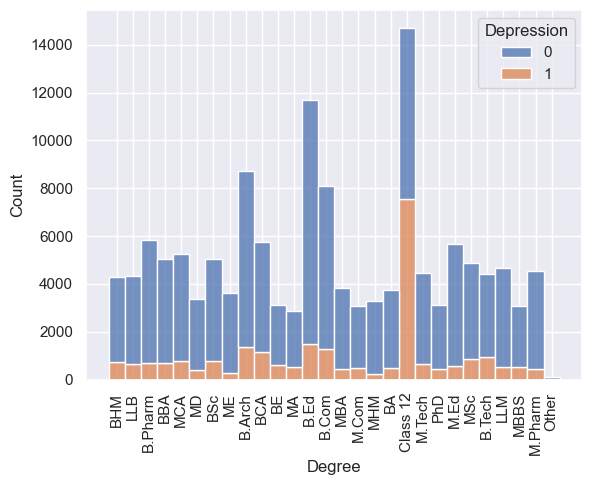

In [30]:
sns_histplot(df, 'Degree')

## Plot again

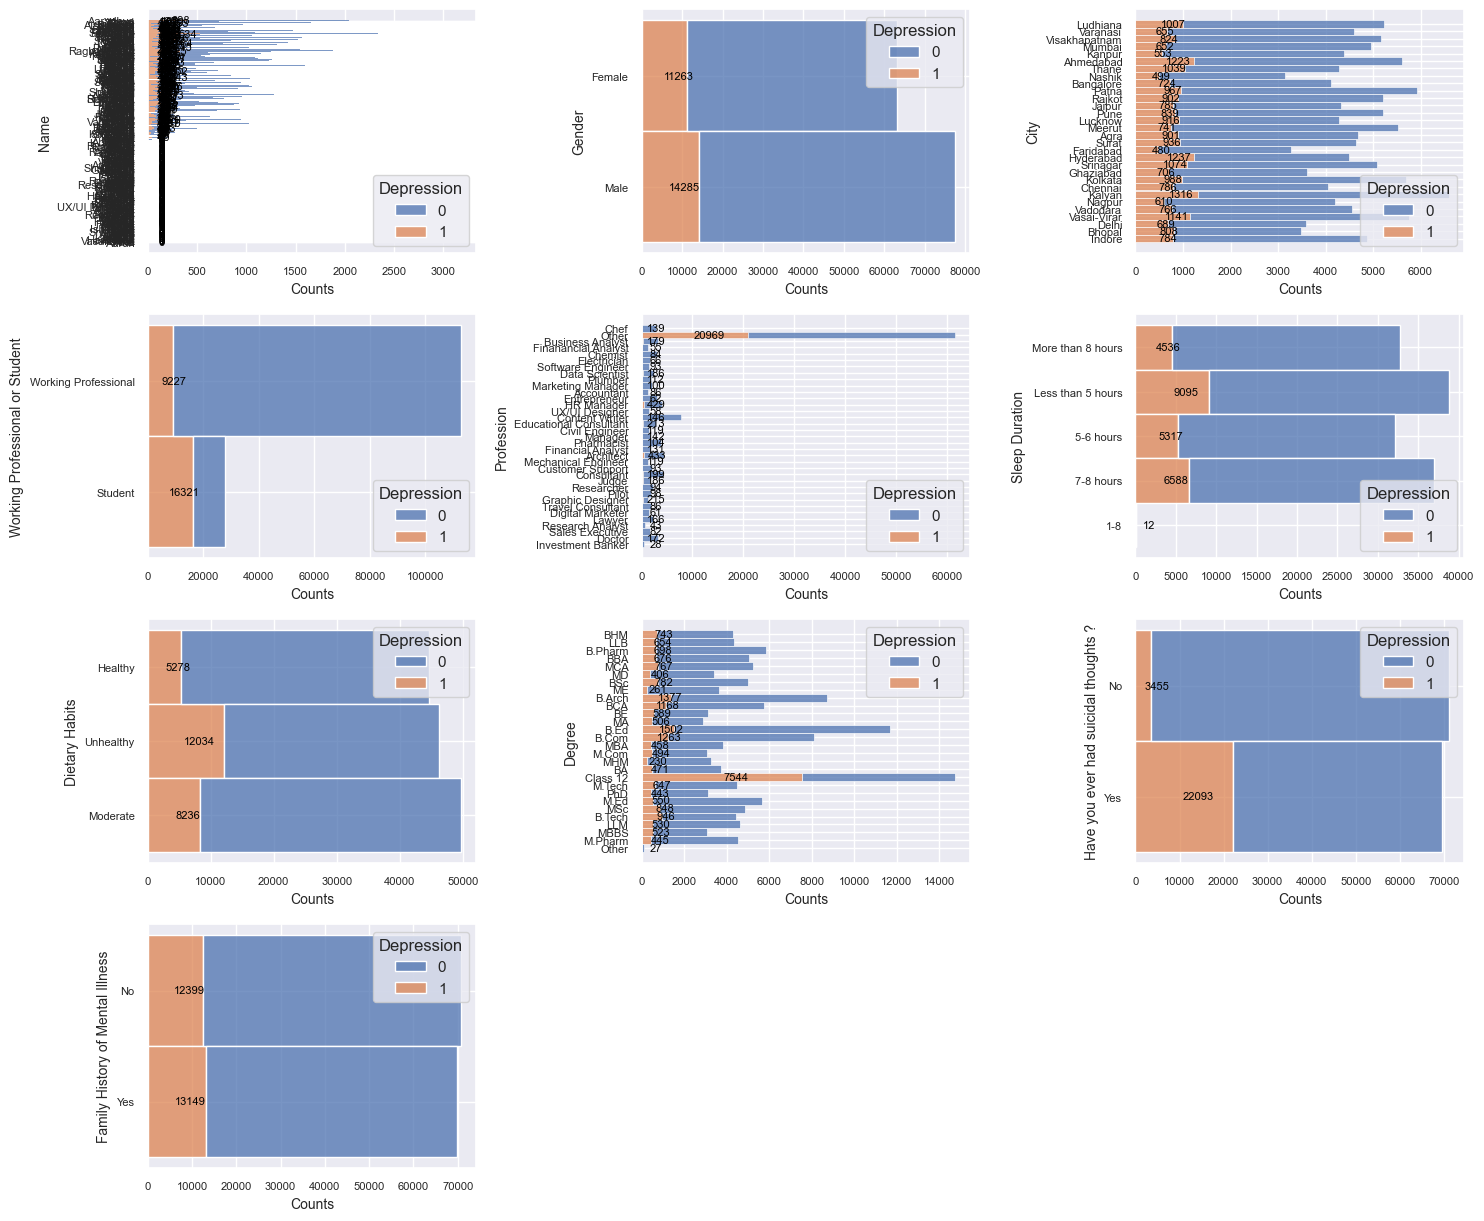

In [31]:
fig = plt.figure(figsize=(15, 15))

for i, feature in enumerate(object_cols):
    ax = fig.add_subplot(5, 3, i+1)
    # df_temp = df[feature].value_counts().reset_index()
    sns.histplot(data=df, y=feature, hue='Depression', multiple="stack")
    # sns.barplot(df_temp, y=feature, x="count", orient="h", alpha=0.8)
    ax.bar_label(
        ax.containers[0], label_type="center", padding=10, color="black", fontsize=8
    )
    ax.set_ylabel(feature, fontsize=10)
    ax.set_xlabel("Counts", fontsize=10)
    ax.tick_params(axis="both", labelsize=8)


fig.tight_layout()
plt.show()

# Numerical Columns

In [32]:
df.describe().round(2).style.format(precision=2).background_gradient(
    cmap="Reds"
)

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140602.00,27871.00,112710.00,27872.00,27871.00,112718.00,140602.00,140598.00,140602.00
mean,40.39,3.14,3.00,7.66,2.95,2.97,6.25,2.99,0.18
std,12.38,1.38,1.41,1.46,1.36,1.42,3.85,1.41,0.39
min,18.00,1.00,1.00,5.03,1.00,1.00,0.00,1.00,0.00
25%,29.00,2.00,2.00,6.29,2.00,2.00,3.00,2.00,0.00
50%,42.00,3.00,3.00,7.77,3.00,3.00,6.00,3.00,0.00
75%,51.00,4.00,4.00,8.92,4.00,4.00,10.00,4.00,0.00
max,60.00,5.00,5.00,10.00,5.00,5.00,12.00,5.00,1.00


In [33]:
float_cols = [col for col in df.columns if (df[col].dtype == "float64")]
float_cols


[
    'Age',
    'Academic Pressure',
    'Work Pressure',
    'CGPA',
    'Study Satisfaction',
    'Job Satisfaction',
    'Work/Study Hours',
    'Financial Stress'
]

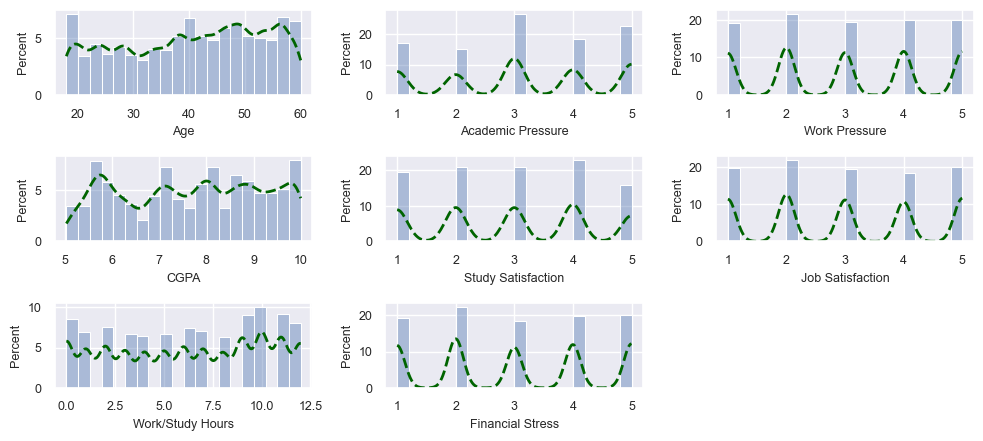

In [34]:
fig = plt.figure(figsize=(10, 10))

for i, feature in enumerate(float_cols):
    ax = fig.add_subplot(7, 3, i + 1)
    sns.histplot(
        df[feature],
        stat="percent",
        kde=True,
        bins=20,
        alpha=0.4,
        line_kws={"lw": 2, "linestyle": "dashed"},
    ).lines[0].set_color("darkgreen")
    plt.tick_params(axis="both", labelsize=9)
    plt.ylabel("Percent", fontsize=9)
    plt.xlabel(feature, fontsize=9)


fig.tight_layout()
plt.show()

In [35]:
df[float_cols].isnull().sum()


Age                        0
Academic Pressure     112731
Work Pressure          27892
CGPA                  112730
Study Satisfaction    112731
Job Satisfaction       27884
Work/Study Hours           0
Financial Stress           4
dtype: int64

## We will just fillna with 0 for now.

In [36]:
df = df.fillna(0)

In [37]:
df.isnull().sum()


Name                                     0
Gender                                   0
Age                                      0
City                                     0
Working Professional or Student          0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [38]:
catalog.save('depression_synthetic_cleaned', df) # save once

[11/29/24 01:55:23] INFO     Saving data to depression_synthetic_cleaned (CSVDataset)...        ]8;id=667707;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=713953;file://C:\Users\divya\miniconda3\envs\mlops\lib\site-packages\kedro\io\data_catalog.py#581\581]8;;\

In [39]:
df_X = df[float_cols]
df_y = df['Depression']
df_X.columns


Index(['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
       'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours',
       'Financial Stress'],
      dtype='object')

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, shuffle=True, test_size=0.3, random_state=42)

## Logistic Regression

### Train

In [41]:
# Train
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict
y_preds = log_reg.predict(X_test)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(log_reg.score(X_test, y_test)))

Accuracy of logistic regression classifier on validation set: 0.92


### Coefficients

In [42]:
pd.DataFrame({'coeff': log_reg.coef_[0]}, 
             index=df_X.columns)

,coeff
Age,-0.165290
Academic Pressure,0.866901
Work Pressure,0.632101
CGPA,0.032063
Study Satisfaction,-0.252293
Job Satisfaction,-0.520366
Work/Study Hours,0.132053
Financial Stress,0.569887


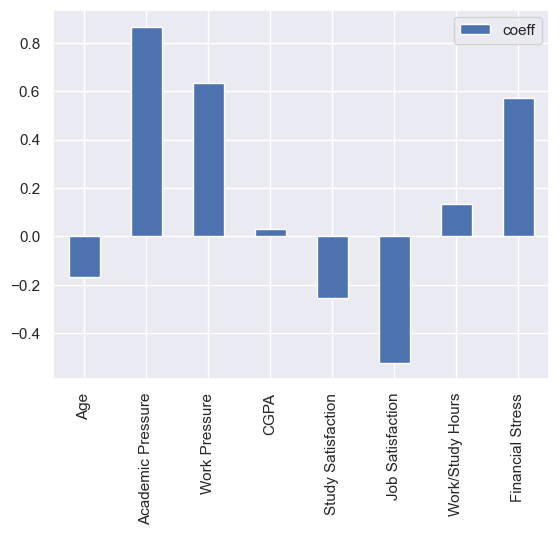

In [43]:
pd.DataFrame({'coeff': log_reg.coef_[0]}, 
             index=df_X.columns).plot(kind = "bar")
plt.show()

### Confusion Matrix

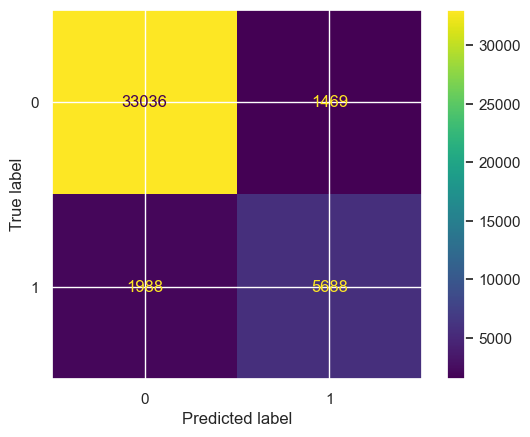

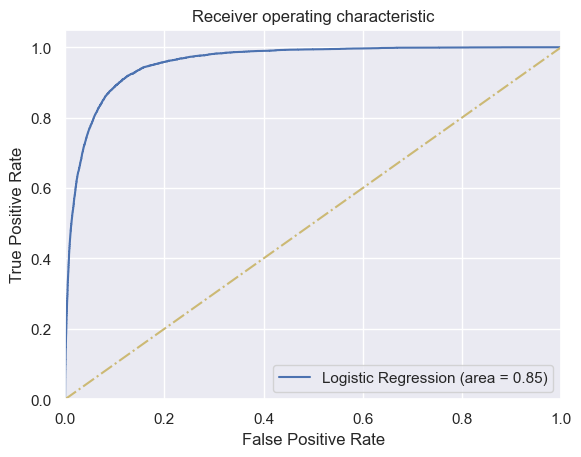

In [44]:
# Comfusion Matrix
cm_np = confusion_matrix(y_test.tolist(), y_preds.tolist())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_np, display_labels = [0, 1])
cm_display.plot()
plt.show()

# ROC Curve
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'y-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [45]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

y_preds = rf_clf.predict(X_test)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(rf_clf.score(X_test, y_test)))

Accuracy of logistic regression classifier on validation set: 0.91


In [46]:
pd.DataFrame({'coeff': rf_clf.feature_importances_}, 
             index=df_X.columns)

,coeff
Age,0.326986
Academic Pressure,0.157021
Work Pressure,0.094374
CGPA,0.112631
Study Satisfaction,0.047443
Job Satisfaction,0.076124
Work/Study Hours,0.106080
Financial Stress,0.079341


<Axes: >

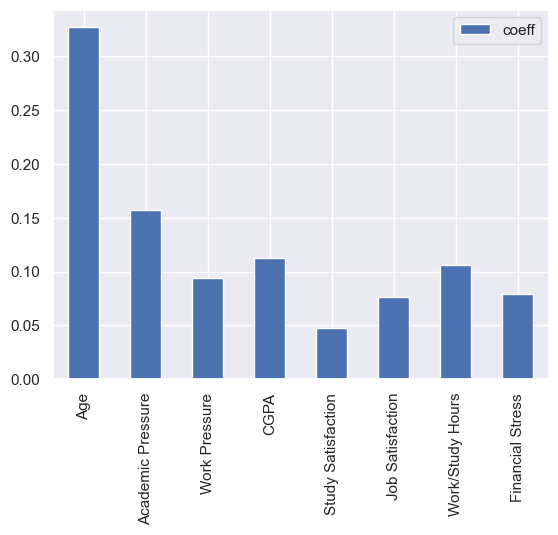

In [47]:
pd.DataFrame({'coeff': rf_clf.feature_importances_}, 
             index=df_X.columns).plot(kind = "bar")

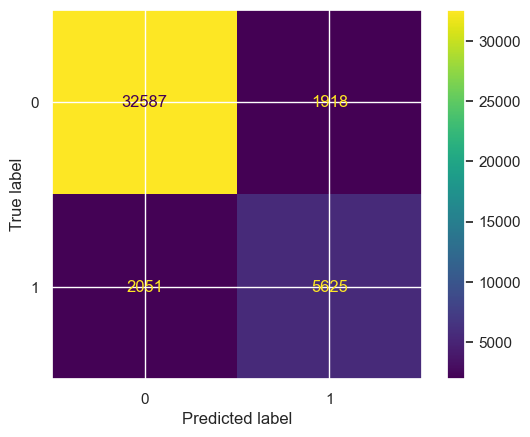

In [48]:
cm_np = confusion_matrix(y_test.tolist(), y_preds.tolist())
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm_np, display_labels = [0, 1])
cm_display.plot()
plt.show()